## Load and Viz Models

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from itertools import product
from scipy.spatial import ConvexHull
import warnings

def find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=1000, min_samples_per_region=5):
    """
    Find linear regions (polytopes) created by a ReLU network on a 2D input plane.
    
    Args:
        model: PyTorch model with ReLU activations (like BaarleNet)
        extent: [xmin, xmax, ymin, ymax] defining the input plane bounds
        grid_resolution: Number of points along each axis for sampling
        min_samples_per_region: Minimum points needed to define a region
    
    Returns:
        List of numpy arrays, each containing corner coordinates of a linear region
    """
    
    def get_relu_pattern(model, x):
        """Get the activation pattern (which ReLUs are active) for input x"""
        pattern = []
        current_x = x
        
        with torch.no_grad():
            for layer in model.layers:
                if isinstance(layer, torch.nn.Linear):
                    current_x = layer(current_x)
                elif isinstance(layer, torch.nn.ReLU):
                    # Record which neurons are active (>0)
                    active = (current_x > 0).float()
                    pattern.append(active)
                    current_x = torch.relu(current_x)
        
        # Flatten and convert to tuple for hashing
        return tuple(torch.cat(pattern, dim=-1).flatten().tolist())
    
    # Create a grid of sample points
    x_vals = np.linspace(extent[0], extent[1], grid_resolution)
    y_vals = np.linspace(extent[2], extent[3], grid_resolution)
    
    # Dictionary to store points by their activation pattern
    pattern_to_points = {}
    
    print(f"Sampling {grid_resolution}x{grid_resolution} points to find activation patterns...")
    
    # Sample points and group by activation pattern
    for i, x in enumerate(x_vals):
        if i % (grid_resolution // 10) == 0:
            print(f"Progress: {i/grid_resolution*100:.1f}%")
            
        for y in y_vals:
            point = torch.tensor([[x, y]], dtype=torch.float32)
            pattern = get_relu_pattern(model, point)
            
            if pattern not in pattern_to_points:
                pattern_to_points[pattern] = []
            pattern_to_points[pattern].append([x, y])
    
    print(f"Found {len(pattern_to_points)} distinct activation patterns")
    
    # Convert regions to convex hulls and find corner points
    linear_regions = []
    
    for pattern, points in pattern_to_points.items():
        if len(points) < min_samples_per_region:
            continue
            
        points_array = np.array(points)
        
        try:
            # Find convex hull of points in this region
            hull = ConvexHull(points_array)
            corners = points_array[hull.vertices]
            linear_regions.append(corners)
            
        except Exception as e:
            warnings.warn(f"Could not compute convex hull for region with {len(points)} points: {e}")
            continue
    
    print(f"Successfully extracted {len(linear_regions)} linear regions")
    
    # Refine boundaries by finding exact hyperplane intersections
    refined_regions = []
    
    for region_corners in linear_regions:
        # For small regions or those touching boundaries, use the sampled corners
        # For larger regions, we could implement exact hyperplane intersection finding
        refined_regions.append(region_corners)
    
    return refined_regions


def visualize_regions(regions, extent=[-1, 1, -1, 1], figsize=(6, 6)):
    """
    Helper function to visualize the found regions (requires matplotlib)
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Polygon
        import matplotlib.colors as mcolors
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Generate colors for each region
        colors = list(mcolors.TABLEAU_COLORS.values())
        
        for i, corners in enumerate(regions):
            color = colors[i % len(colors)]
            
            # Create polygon for this region
            polygon = Polygon(corners, alpha=0.3, facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(polygon)
            
            # Mark corners
            # ax.scatter(corners[:, 0], corners[:, 1], c='red', s=10, zorder=5, alpha=0.5)
        
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Linear Regions of ReLU Network ({len(regions)} regions)')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("matplotlib not available for visualization")

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
# belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
# netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords_all, belgium_coords_all))
y=np.concatenate((np.zeros(len(netherlands_coords_all)), np.ones(len(belgium_coords_all)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [4]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

In [5]:
X.shape, y.shape, X_tensor.shape, y_tensor.shape

((855665, 2), (855665,), torch.Size([855665, 2]), torch.Size([855665]))

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## Single Layer

## Shallow [2]

0.7268977929446687


<Figure size 640x480 with 0 Axes>

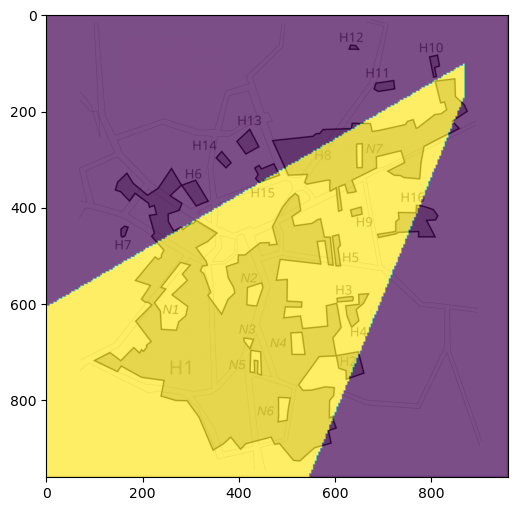

In [7]:
model_path='../models/2_1.pth'
model = BaarleNet([2])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 4 distinct activation patterns
Successfully extracted 4 linear regions


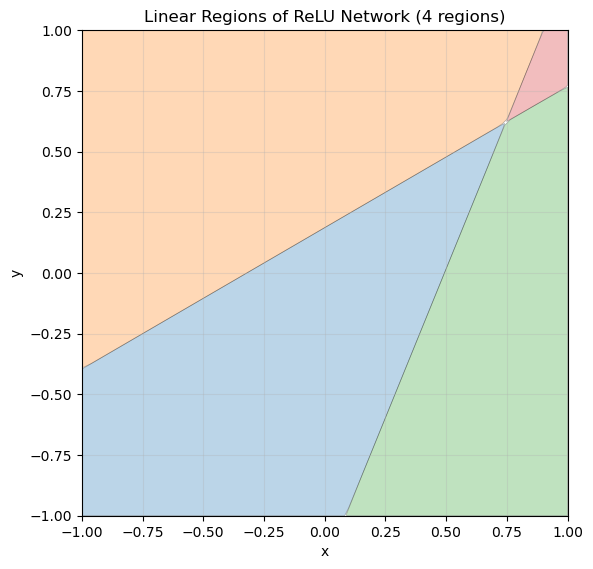

In [8]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## Shallow [3]

0.8173490793710155


<Figure size 640x480 with 0 Axes>

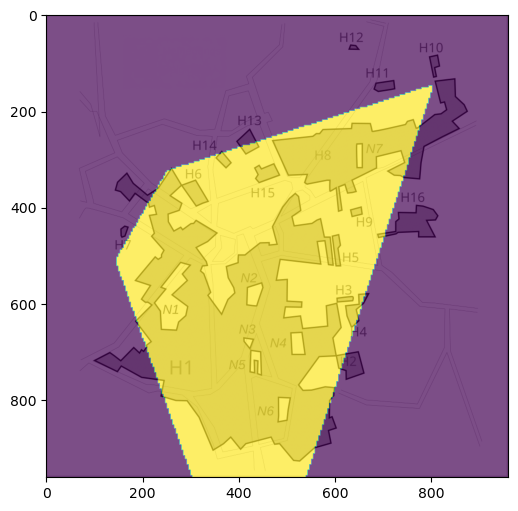

In [9]:
model_path='../models/3_1.pth'
model = BaarleNet([3])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 5 distinct activation patterns
Successfully extracted 5 linear regions


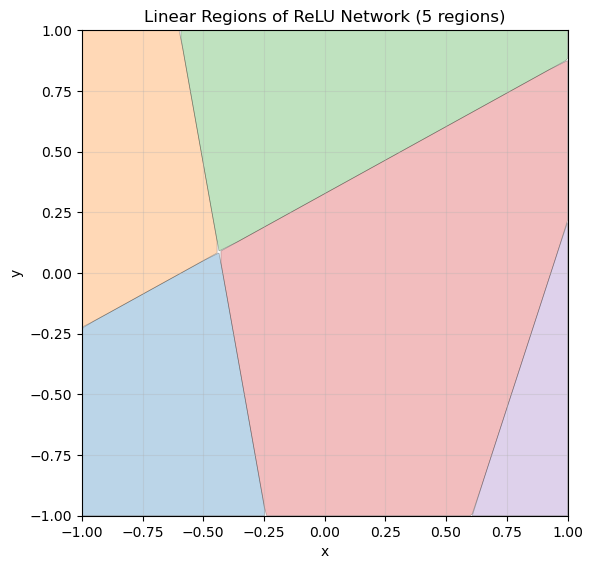

In [10]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## Shallow [4]

## Shallow [8]

## Shallow [16]

## Shallow [32]

## Shallow [64]

0.9358557379348226


<Figure size 640x480 with 0 Axes>

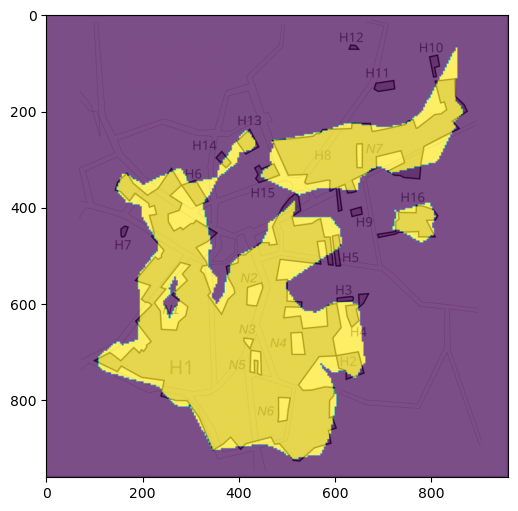

In [11]:
model=torch.load('../models/one_layer_64_nuerons_long.pt')

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 630 distinct activation patterns


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13792/4032999566.py:77: UserWarning: Could not compute convex hull for region with 8 points: QH6013 qhull input error: input is less than 2-dimensional since all points have the same x coordinate   -1

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 587411234  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.055  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

  warnings.warn(f"Could not compute convex hull for region with {len(points)} points: {e}")
/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13792/4032999566.py:77: UserWarning: Could not compute convex hull for region with 12 points: QH6013 qhull input error: input is less than 2-dimensional since all points have the same x coordinate   -1

While executing:  | qhull i Qt
Opt

Successfully extracted 515 linear regions


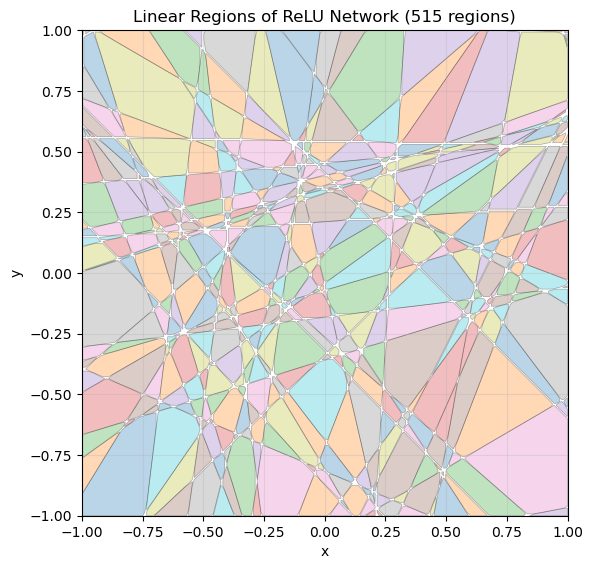

In [12]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## Shallow [128]

## Shallow [256]

## Shallow [512]

## Shallow [1024]

## Shallow [10k]

In [13]:
# model=torch.load('../models/one_layer_10k_neurons_long.pt')

# outputs_batch = model(X_tensor)
# accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

# print(accuracy); viz_descision_boundary(model)

## Shallow [100k]

In [14]:
# model=torch.load('../models/one_layer_100k_neurons_long.pt', weights_only=False)

# outputs_batch = model(X_tensor)
# accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

# print(accuracy); viz_descision_boundary(model)

## [2,2]

0.8239673236605447


<Figure size 640x480 with 0 Axes>

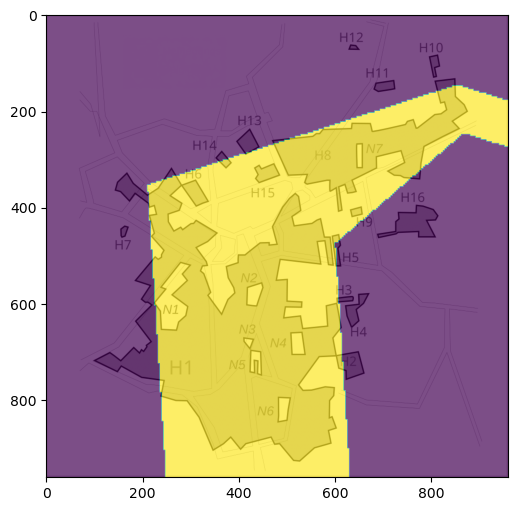

In [15]:
model_path='../models/2_2_1.pth'
model = BaarleNet([2,2])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

In [16]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 11 distinct activation patterns
Successfully extracted 11 linear regions


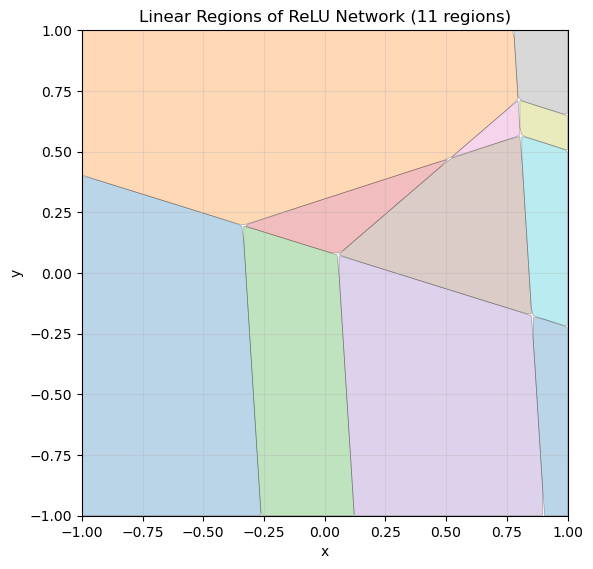

In [17]:
visualize_regions(regions)

## [3,3]

0.8430659194895198


<Figure size 640x480 with 0 Axes>

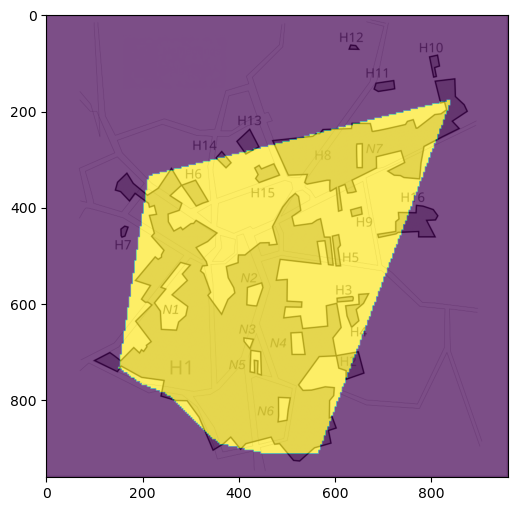

In [18]:
model_path='../models/3_3_1.pth'
model = BaarleNet([3,3])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 20 distinct activation patterns
Successfully extracted 20 linear regions


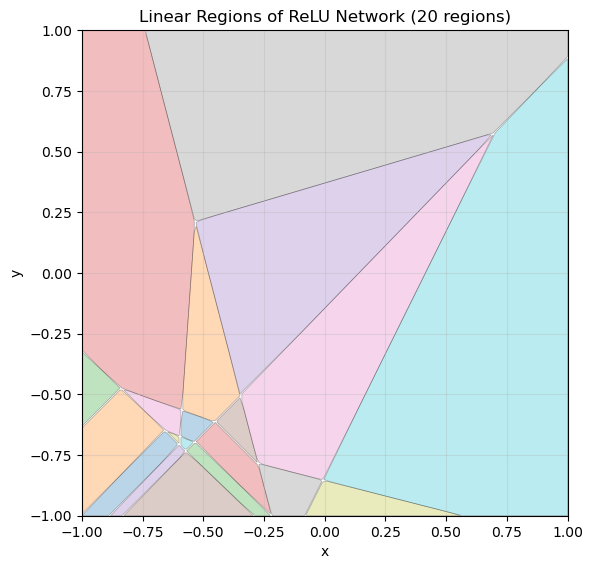

In [19]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## [8, 8]

0.9241572344316993


<Figure size 640x480 with 0 Axes>

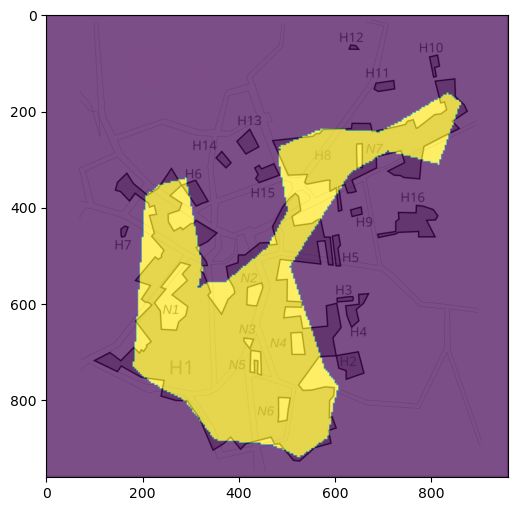

In [20]:
model_path='../models/8_8_1.pth'
model = BaarleNet([8,8])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 65 distinct activation patterns
Successfully extracted 64 linear regions


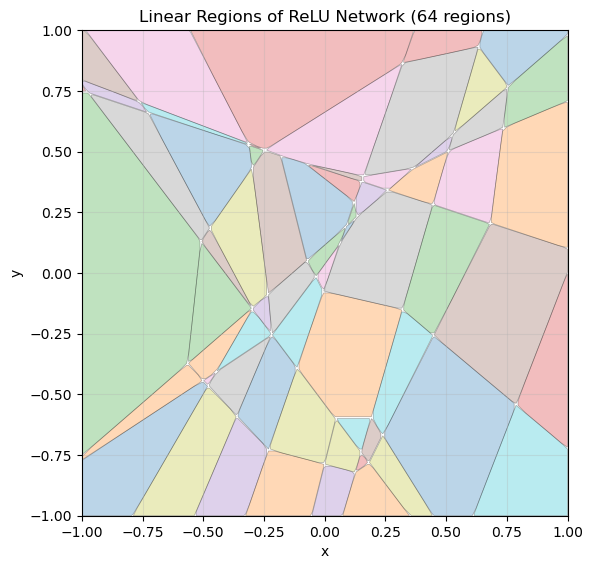

In [21]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## [16, 16]

0.9421642815821613


<Figure size 640x480 with 0 Axes>

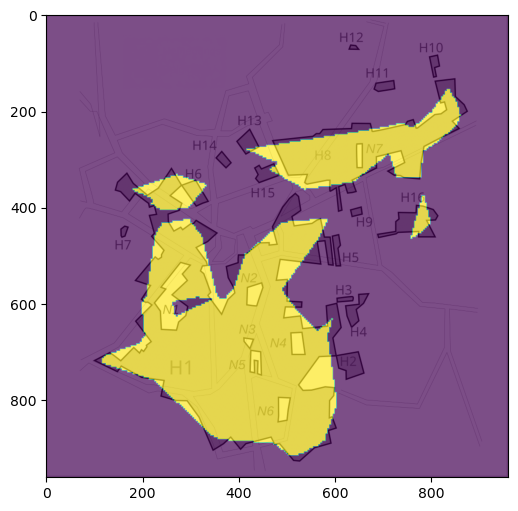

In [22]:
model_path='../models/16_16_1.pth'
model = BaarleNet([16,16])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 237 distinct activation patterns
Successfully extracted 207 linear regions


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13792/4032999566.py:77: UserWarning: Could not compute convex hull for region with 6 points: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 587579304  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.039  Error-roundoff 6.8e-16  _one-merge 3.4e-15
  _near-inside 1.7e-14  Visible-distance 1.4e-15  U-max-coplanar 1.4e-15
  Width-outside 2.7e-15  _wide-facet 8.1e-15  _maxoutside 4.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3): -0.78 -0.49
- p5(v2): -0.75 -0.49
- p0(v1): -0.79 -0.49

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 6.8e-16.  The center p

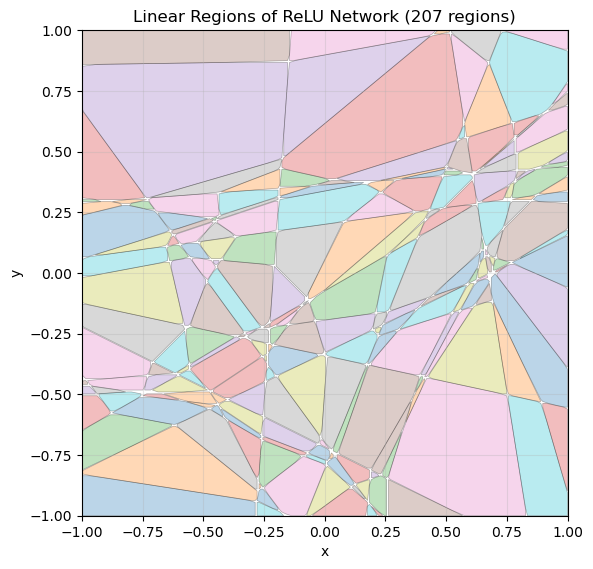

In [23]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

## [2,2,2]

0.8390386424593737


<Figure size 640x480 with 0 Axes>

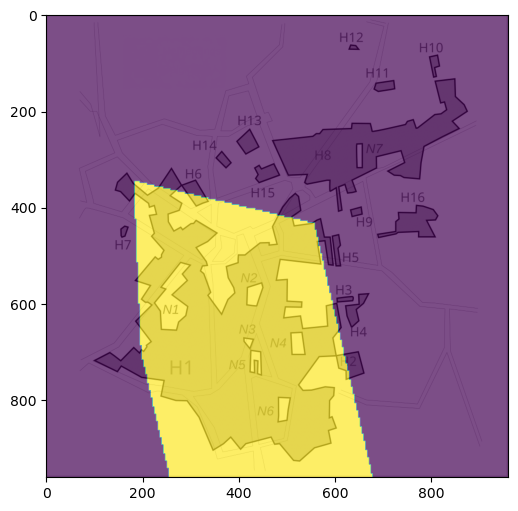

In [24]:
model_path='../models/2_2_2_1.pth'
model = BaarleNet([2,2,2])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

## [16, 16, 16]

0.9488514780901404


<Figure size 640x480 with 0 Axes>

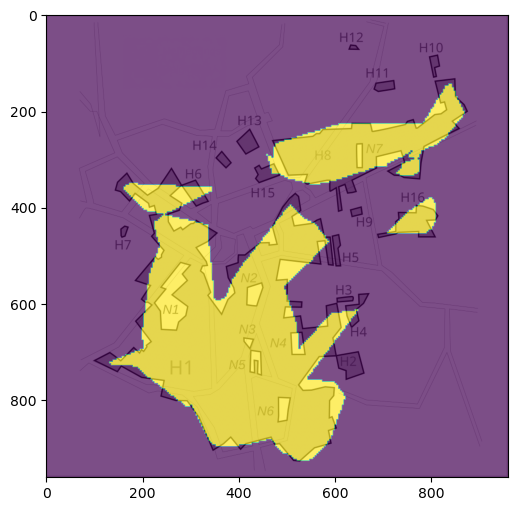

In [25]:
model_path='../models/16_16_16_1.pth'
model = BaarleNet([16,16,16])
model.load_state_dict(torch.load(model_path))

outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); viz_descision_boundary(model)

Sampling 256x256 points to find activation patterns...
Progress: 0.0%
Progress: 9.8%
Progress: 19.5%
Progress: 29.3%
Progress: 39.1%
Progress: 48.8%
Progress: 58.6%
Progress: 68.4%
Progress: 78.1%
Progress: 87.9%
Progress: 97.7%
Found 514 distinct activation patterns
Successfully extracted 419 linear regions


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13792/4032999566.py:77: UserWarning: Could not compute convex hull for region with 7 points: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 587646532  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.047  Error-roundoff 2.8e-16  _one-merge 1.4e-15
  _near-inside 7e-15  Visible-distance 5.6e-16  U-max-coplanar 5.6e-16
  Width-outside 1.1e-15  _wide-facet 3.3e-15  _maxoutside 1.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p4(v3): -0.22 -0.29
- p6(v2): -0.21 -0.28
- p0(v1): -0.25 -0.33

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.8e-16.  The center poi

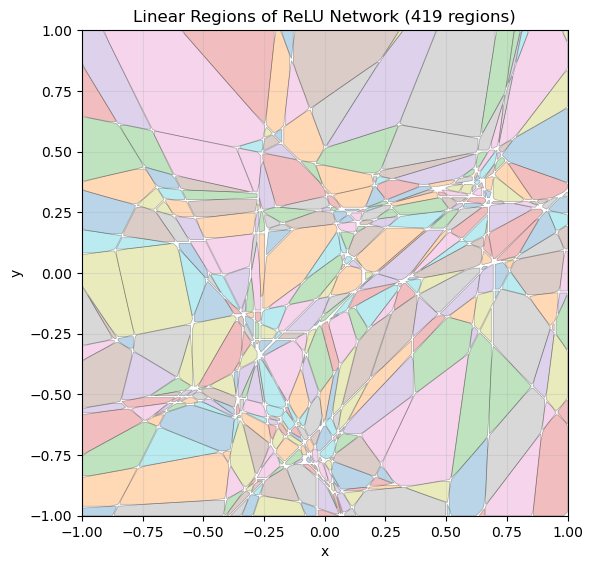

In [26]:
regions = find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=256)
visualize_regions(regions)

Cools.